# Нейросети и вероятностные модели

**Разработчик: Алексей Умнов**

# Авторегрессионные модели

Мы поработаем с авторегрессионными моделями на примере архитектуры PixelCNN. Мы обучим модель для задачи генерации изображений и для задачи дорисовывания недостающих частей изображения.

### LCD digits dataset

В качестве примера мы возьмем датасет из простых LCD-цифр. Ниже приведен код, который его загружает и рисует примеры сэмплов.

Источник датасета: https://gist.github.com/benjaminwilson/b25a321f292f98d74269b83d4ed2b9a8#file-lcd-digits-dataset-nmf-ipynb

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets, utils

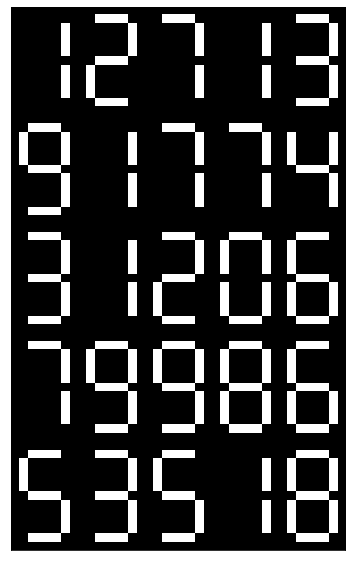

In [2]:
from utils import LcdDigits, IMAGE_WIDTH, IMAGE_HEIGHT

BATCH_SIZE = 100

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)


def show_as_image(image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.xticks([]); plt.yticks([])
    
def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])

for batch, _ in train_loader:
    show_as_image(batch_images_to_one(batch[:25]), figsize=(10, 10))
    break

Здесь специально выбран простой датасет, так как вероятностные модели обычно требуют больших ресурсов. Также обратите внимание, что хотя данные очень простые (фактически всего 10 разных сэмплов), они находятся в пространстве значительно большей размерности ($2^{8 \times 13}$). Мы будем подавать модели сырые пиксели на вход, и будем хотеть, чтобы она нашла в них правильные зависимости и научилась строить только валидные изображения.

### PixelCNN

Коротко вспомним, что такое PixelCNN. Авторегрессионные модели в общем виде моделируют распределения на векторах $x = (x_1, \ldots, x_N)$ в виде:

$$
    p(x) = \prod_{i=1}^{N} p(x_i \mid x_1, \ldots, x_{i-1}).
$$

Распределения $p(x_i \mid x_1, \ldots, x_{i-1})$ можно моделировать при помощи нейронных сетей, которые получают на вход значения $x_1, \ldots, x_{i-1}$ и выдают распределение вероятностей для значений $x_i$. Так как входов здесь переменное число, можно использовать рекуррентные сети (например, PixelRNN), но неплохо работает и более простая модель &mdash; PixelCNN, &mdash; которая подает на вход не все значения $x_1, \ldots, x_{i-1}$, а только соседние на некотором расстоянии с помощью сверточных слоев.

![pixelcnn](pixelcnn.png)



Для того, чтобы для данного пикселя подавать на вход только значения идущие ранее, вместо обычных сверток нужно использовать маскированные свертки. Напишите недостающий код, чтобы создать соответствующие маски и потом сделайте из них слой для pytorch. Такие слои можно добавлять последовательно, сохраняя корректные зависимости, при этом во всех слоях кроме первого можно использовать центральный пиксель. У вас должны получаться вот такие маски (с `include_center=False` и с `include_center=True` соответственно):

![](mask_with_center.png)
![](mask_no_center.png)

Hint: можно умножить на маску не входы, а веса.

In [3]:
def causal_mask(width, height, starting_point):
    
    mask = torch.cat((
        torch.ones(starting_point[0], width),
        torch.cat((
            torch.ones(1, starting_point[1] + 1),
            torch.zeros(1, width - starting_point[1] - 1)
        ), 1),
        torch.zeros(height - starting_point[0] - 1, width)
    ), 0)
    return mask.numpy().T

def conv_mask(height, width, include_center=False):
    cm = causal_mask(
        width, height, 
        starting_point=(height//2, width//2 + include_center - 1))
    return 1.0 * torch.Tensor(cm)

In [4]:
conv_mask(5, 5, True)

tensor([[1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.]])

In [5]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, include_center, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.include_center = include_center
        cm = conv_mask(
            *self.weight.data.shape[2:], include_center
        )
        self.weight.data = torch.matmul(self.weight, cm)
        
    # YOUR CODE
    



Теперь соберите сеть с несколькими слоями маскированных сверток и обучите ее.

Hint 1: в задаче хорошо помогает сверточный слой 1x1 в конце.

Hint 2: если ошибиться и нарушить казуальность (т.е. сделать зависимости вперед), то обучаться будет хорошо, а генерировать плохо.

In [6]:
class PixelCNN(nn.Module):
    N_PIXELS_OUT = 2 # binary 0/1 pixels
    
    def __init__(self, n_channels, kernel_size, padding):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d(
                False,
                in_channels=1,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            MaskedConv2d(
                True,
                in_channels=n_channels,
                out_channels=n_channels,
                kernel_size=kernel_size,
                padding=padding
            ),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=n_channels,
                out_channels=self.N_PIXELS_OUT,
                kernel_size=(1, 1)
            )
        )
                 
    # YOUR CODE
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

In [7]:
N_EPOCHS = 25
LR = 0.005

cnn = PixelCNN(n_channels=4, kernel_size=7, padding=3)
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

Обратите внимание, что полученной сети достаточно подать на вход изображение, и на выходе получится распределение для значений каждого пикселя. Осталось только минимизировать кросс-энтропию этих значений и пикселей примеров в выборке. В случае успеха итоговая кросс-энтропия будет около 0.02.

In [8]:
import torch.nn.functional as F


for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # TRAIN
        output = cnn(images)
        target = images[:,0].long()
        loss = F.cross_entropy(output, target)
        
        # YOUR CODE
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, N_EPOCHS, loss.data.item()))

Epoch [1/25], Loss: 0.7670
Epoch [2/25], Loss: 0.1364
Epoch [3/25], Loss: 0.0304
Epoch [4/25], Loss: 0.0126
Epoch [5/25], Loss: 0.0071
Epoch [6/25], Loss: 0.0046
Epoch [7/25], Loss: 0.0033
Epoch [8/25], Loss: 0.0024
Epoch [9/25], Loss: 0.0019
Epoch [10/25], Loss: 0.0015
Epoch [11/25], Loss: 0.0013
Epoch [12/25], Loss: 0.0011
Epoch [13/25], Loss: 0.0009
Epoch [14/25], Loss: 0.0008
Epoch [15/25], Loss: 0.0007
Epoch [16/25], Loss: 0.0006
Epoch [17/25], Loss: 0.0005
Epoch [18/25], Loss: 0.0005
Epoch [19/25], Loss: 0.0004
Epoch [20/25], Loss: 0.0004
Epoch [21/25], Loss: 0.0003
Epoch [22/25], Loss: 0.0003
Epoch [23/25], Loss: 0.0003
Epoch [24/25], Loss: 0.0003
Epoch [25/25], Loss: 0.0002




При генерации изображений можно начинать с пустого изображения, а можно подавать какие-то начальные пиксели. Допишите функцию генерации и проверьте ее для задачи генерации (на вход пустое изображения) и для задачи дорисовывания (на вход - верхняя часть изображения).

У вас должны получиться разумные изображения цифр, допускается небольшая доля "плохих" изображений.

*Упражнение:* почему при одинаковых пустых входных изображениях получаются разные изображения на выходе?

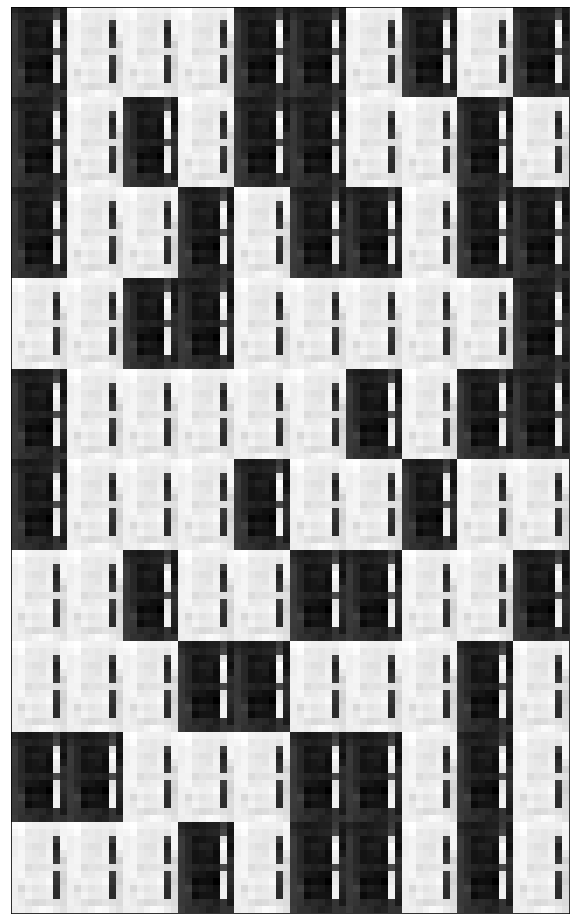

In [38]:
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):

    samples = torch.from_numpy(
        starting_image if starting_image is not None else 
        np.zeros((n_samples * n_samples, 1, IMAGE_HEIGHT, IMAGE_WIDTH))).float()

    cnn.train(False)
    optimizer.zero_grad()
    out = cnn(samples)
    idx = np.random.choice([0, 1], size=out.shape[0])
    idxs = [(i, idx) for i, idx in enumerate(idx)]
    samples = torch.cat([out[idx_pair[0], idx_pair[1]] for idx_pair in idxs]).view(-1, 13, 8).detach()
    return samples.numpy()


show_as_image(batch_images_to_one(generate_samples(n_samples=10)), figsize=(10, 20))

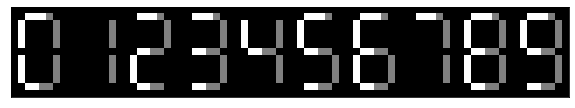

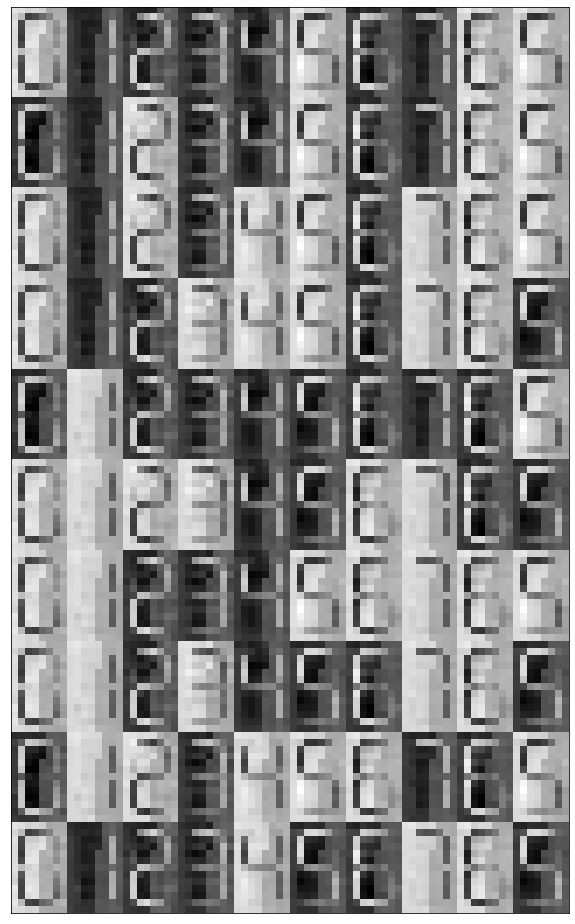

In [39]:
from utils import random_digits

n_images = 10
starting_point = (4, 3)

mask = causal_mask(IMAGE_HEIGHT, IMAGE_WIDTH, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(10)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))